# Setup

Perform all necessary imports up front

In [ ]:
!pip install --quiet --quiet armory-library armory-examples[cv]

In [ ]:
%matplotlib inline

# armory-library imports
import armory.engine
import armory.evaluation
import armory.logging
import armory.results
import armory.utils

# armory-examples imports
import armory.examples.image_classification.food101 as food101

In [ ]:
armory.logging.configure_logging()

We configure logging with sane defaults using this armory-provided convenience function.

# Define the Evaluation

In [ ]:
evaluation = armory.evaluation.Evaluation(
    name="image-classification-food101",
    description="Image classification of food-101",
    author="TwoSix",
)

## Model

From our `food101` example, we will load a model from HuggingFace that has
already been fine-tuned on the food-101 dataset. We also wrap this model in an
Adversarial Robustness Toolbox (ART) estimator so that we can use an ART attack
against the model.

In [ ]:
with evaluation.autotrack():
    model, art_estimator = food101.load_model()
evaluation.use_model(model)

## Dataset

From our `food101` example, we will load the food-101 dataset from HuggingFace.

In order to get a variety of classes in this demonstration, we're shuffling the
dataset with a fixed seed.

In [ ]:
with evaluation.autotrack():
    dataset, labels = food101.load_huggingface_dataset(
        batch_size=2, shuffle=True, seed=8675309,
    )
evaluation.use_dataset(dataset)

## Attack

From our `food101` example, we create a Projected Gradient Descent (PGD) attack
using the Adversarial Robustness Toolbox (ART).

In [ ]:
with evaluation.autotrack():
    attack = food101.create_pgd_attack(art_estimator)

## Metrics

From our `food101` example, we create the metrics to be collected during the
evaluation. These include an L-infinity norm distance between unperturbed and
perturbed input, and a categorical accuracy between the natural labels and the
predicted labels.

In [ ]:
evaluation.use_metrics(food101.create_metrics())

## Exporters

From our `food101` example, we create the exporters used to record sample images
during the evaluation.

In [ ]:
evaluation.use_exporters(food101.create_exporters(model, export_every_n_batches=1))

## Evaluation Chains

We will define two perturbation chains: `benign` and `attack`. The benign chain
does not apply any perturbations to the data, giving us the intrinsic
performance of the model. The attack chain will give us the performance of the
model under adversarial attack.

In [ ]:
with evaluation.add_chain("benign"):
    pass

with evaluation.add_chain("attack") as chain:
    chain.add_perturbation(attack)

# Execute the Evaluation

We create an evaluation engine which will handle the application of all
perturbations, obtaining predictions from the model, collecting metrics, and
exporting of samples.

In [ ]:
engine = armory.engine.EvaluationEngine(
    evaluation,
    limit_test_batches=2,
)
results = engine.run()
chains = [results.children["benign"], results.children["attack"]]

In [ ]:
armory.results.plot_metrics(*chains)

Metric,benign,attack
accuracy,1.000,0.500
epoch,0.000,0.000
linf_norm,0.000,0.003
precision,1.000,0.333
recall,1.000,0.333


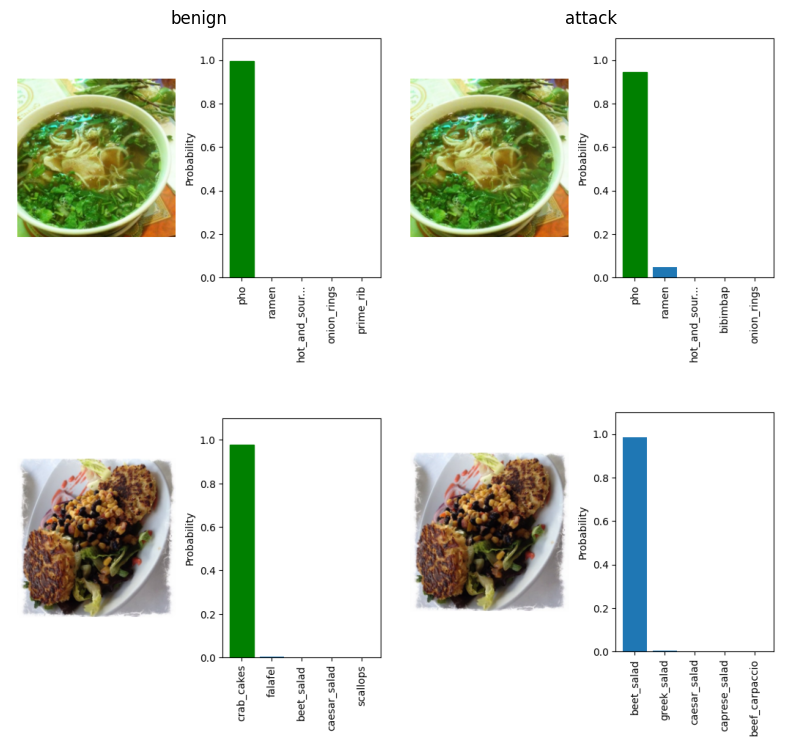

In [ ]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(0)
            .sample(sample_idx)
            .classification.plot(labels=labels, top_k=5)
            for chain in chains
        ]
        for sample_idx in range(2)
    ],
    columns=[chain.run_name for chain in chains],
    figsize=(8, 8),
)

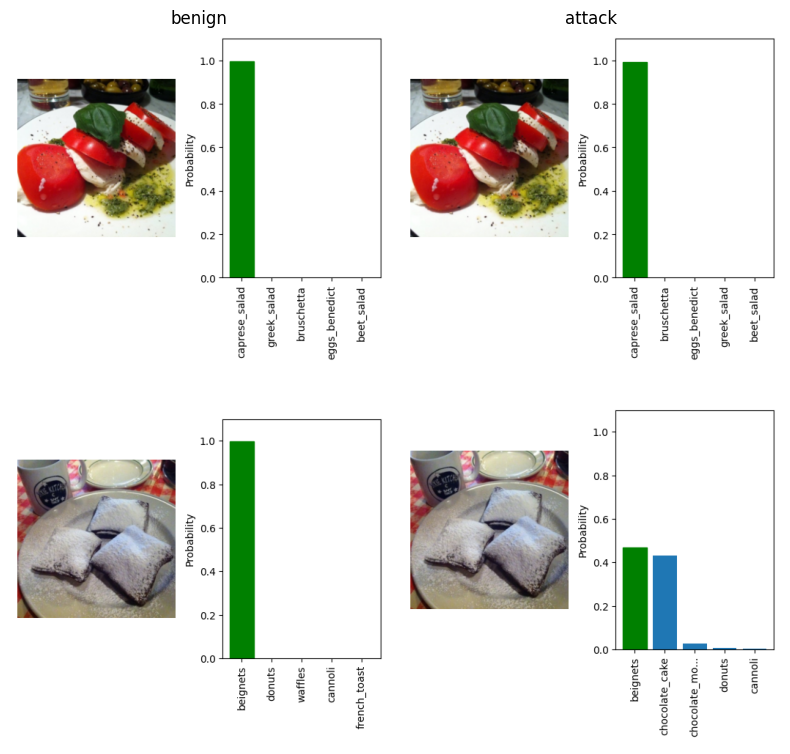

In [ ]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(1)
            .sample(sample_idx)
            .classification.plot(labels=labels, top_k=5)
            for chain in chains
        ]
        for sample_idx in range(2)
    ],
    columns=[chain.run_name for chain in chains],
    figsize=(8, 8),
)

# Additional Code

In order to make this notebook concise some helper functions have been imported
from [armory.examples.image_classification.food101](https://github.com/twosixlabs/armory-library/blob/master/examples/src/armory/examples/image_classification/food101.py)
